# 1.Librerías

In [1]:
%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 65.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0
Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: optuna
    Found existing installation: optuna 4.0.0
    Uninstalling optuna-4.0.0:
      Successfully uninstalled optuna-4.0.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

/home/ingceciliaconde/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/ingceciliaconde/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2.Datos

In [35]:
#seteo carpeta de trabajo y archivo
dataset_path = '/home/ingceciliaconde/buckets/b1/datasets'
modelos_path = '/home/ingceciliaconde/buckets/b1/datasets/modelos'
db_path = '/home/ingceciliaconde/buckets/b1/datasets/db'
exp_path ='/home/ingceciliaconde/buckets/b1/exp'
dataset_file = 'competencia_02_fe_v1.csv.gz'


In [5]:
#leo archivo
data = pd.read_csv(f"{dataset_path}/{dataset_file}")


In [10]:
data.shape

(4735593, 472)

In [6]:
#semillas y valores de ganancia
semilla=[100183,200003,300017,700001,800011]
ganancia_acierto = 273000
costo_estimulo = 7000

In [11]:
#meses
mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_6 = [202101, 202102, 202103, 202104, 202105, 202106]
mes_train_12 = [202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]
mes_test = 202108

In [12]:
mes_train=mes_train_12 #si uso 6 meses, cambiar a mes_train_6 y si uso all, cambiar a mes_train_all

## Darle valor a las clases

In [13]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

En particular, sumaremos la clase BAJA+1, que es estructuralmente muy similar a BAJA+2, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [14]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0) # solo baja +2
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1) #ambas bajas

In [15]:
#filtrar por baja + 2 y mostrar clase ternaria clase binaria
data[data['clase_ternaria'] == 'BAJA+2'][['clase_ternaria', 'clase_binaria1', 'clase_binaria2']].head()


clase_ternaria  clase_binaria1  clase_binaria2
279          BAJA+2               1               1
394          BAJA+2               1               1
600          BAJA+2               1               1
1325         BAJA+2               1               1
2037         BAJA+2               1               1

# 3.Separa Test y Train

In [16]:
train_data = data[data['foto_mes'].isin(mes_train)] # train_data = data[data['foto_mes'] == mes_train]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1'] #SOLO BAJA+2
y_train_binaria2 = train_data['clase_binaria2'] #TODAS LAS BAJAS
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

# 4.Funcion de Ganancia

In [17]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

# 5.Optimizacion del Modelo


In [18]:
#optimizacion de hiperparametros
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 50, 2000), #cambie de 1 a 50
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semilla[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000, # modificar, subit y subir... y descomentar la línea inferior
        callbacks=[lgb.early_stopping(stopping_rounds=int(50 + 5 / learning_rate[0]))],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semilla[0]
    )
    
    # Calculo la ganancia máxima y la mejor iteración donde se obtuvo dicha ganancia.
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5



In [19]:
#almacenamiento de los resultados
storage_name = "sqlite:///" + db_path + "optimization_lgbm_v5.db"
study_name = "exp_lgbm_v5_12meses_fe_v1"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-11-17 19:21:26,440] A new study created in RDB with name: exp_lgbm_v5_12meses_fe_v1


In [20]:
study.optimize(objective, n_trials=100) # subir subir

Training until validation scores don't improve for 67 rounds
Did not meet early stopping. Best iteration is:
[962]	cv_agg's valid gan_eval: 2.00273e+08 + 1.52097e+07


[I 2024-11-17 19:49:46,570] Trial 0 finished with value: 1001364000.0 and parameters: {'num_leaves': 64, 'learning_rate': 0.2923813684601005, 'min_data_in_leaf': 495, 'feature_fraction': 0.6245548990464163, 'bagging_fraction': 0.652047440560122}. Best is trial 0 with value: 1001364000.0.


Training until validation scores don't improve for 204 rounds
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid gan_eval: 2.03424e+08 + 7.04316e+06


[I 2024-11-17 20:43:53,493] Trial 1 finished with value: 1017121000.0 and parameters: {'num_leaves': 24, 'learning_rate': 0.032289255832193726, 'min_data_in_leaf': 1257, 'feature_fraction': 0.49609990575451746, 'bagging_fraction': 0.6146807292021026}. Best is trial 1 with value: 1017121000.0.


Training until validation scores don't improve for 86 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid gan_eval: 1.78858e+08 + 1.0264e+07


[I 2024-11-17 20:50:26,878] Trial 2 finished with value: 894292000.0 and parameters: {'num_leaves': 94, 'learning_rate': 0.13557945508052152, 'min_data_in_leaf': 54, 'feature_fraction': 0.12181927788216014, 'bagging_fraction': 0.637143475622567}. Best is trial 1 with value: 1017121000.0.


Training until validation scores don't improve for 85 rounds
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid gan_eval: 2.19442e+08 + 7.15626e+06


[I 2024-11-17 21:13:17,826] Trial 3 finished with value: 1097208000.0 and parameters: {'num_leaves': 53, 'learning_rate': 0.1416589422616823, 'min_data_in_leaf': 835, 'feature_fraction': 0.9695321527116126, 'bagging_fraction': 0.5673626523606246}. Best is trial 3 with value: 1097208000.0.


Training until validation scores don't improve for 68 rounds
Early stopping, best iteration is:
[546]	cv_agg's valid gan_eval: 1.90826e+08 + 7.2536e+06


[I 2024-11-17 21:35:56,174] Trial 4 finished with value: 954128000.0 and parameters: {'num_leaves': 15, 'learning_rate': 0.2766003023401989, 'min_data_in_leaf': 1524, 'feature_fraction': 0.12000365316963524, 'bagging_fraction': 0.9381625342016751}. Best is trial 3 with value: 1097208000.0.


Training until validation scores don't improve for 81 rounds
Early stopping, best iteration is:
[873]	cv_agg's valid gan_eval: 2.03787e+08 + 6.77939e+06


[I 2024-11-17 22:10:17,628] Trial 5 finished with value: 1018934000.0 and parameters: {'num_leaves': 15, 'learning_rate': 0.15712508357384258, 'min_data_in_leaf': 538, 'feature_fraction': 0.12877203068779275, 'bagging_fraction': 0.7605885383753913}. Best is trial 3 with value: 1097208000.0.


Training until validation scores don't improve for 290 rounds
Did not meet early stopping. Best iteration is:
[994]	cv_agg's valid gan_eval: 2.15279e+08 + 8.30452e+06


[I 2024-11-17 22:38:06,600] Trial 6 finished with value: 1076397000.0 and parameters: {'num_leaves': 99, 'learning_rate': 0.0207820963879401, 'min_data_in_leaf': 467, 'feature_fraction': 0.7702129552547866, 'bagging_fraction': 0.8263018640725187}. Best is trial 3 with value: 1097208000.0.


Training until validation scores don't improve for 70 rounds
Early stopping, best iteration is:
[13]	cv_agg's valid gan_eval: 1.60446e+08 + 6.68343e+06


[I 2024-11-17 22:41:46,350] Trial 7 finished with value: 802228000.0 and parameters: {'num_leaves': 91, 'learning_rate': 0.24834672468003044, 'min_data_in_leaf': 259, 'feature_fraction': 0.8127750020648584, 'bagging_fraction': 0.995403536692734}. Best is trial 3 with value: 1097208000.0.


Training until validation scores don't improve for 68 rounds
Did not meet early stopping. Best iteration is:
[983]	cv_agg's valid gan_eval: 2.22254e+08 + 7.20242e+06


[I 2024-11-17 23:41:28,373] Trial 8 finished with value: 1111271000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.2666051250753679, 'min_data_in_leaf': 1862, 'feature_fraction': 0.5575028848987957, 'bagging_fraction': 0.14248984552287391}. Best is trial 8 with value: 1111271000.0.


Training until validation scores don't improve for 72 rounds
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid gan_eval: 2.00889e+08 + 7.98608e+06


[I 2024-11-18 00:33:08,994] Trial 9 finished with value: 1004444000.0 and parameters: {'num_leaves': 18, 'learning_rate': 0.22686585587918842, 'min_data_in_leaf': 1143, 'feature_fraction': 0.4775074138812585, 'bagging_fraction': 0.39788368133359964}. Best is trial 8 with value: 1111271000.0.


Training until validation scores don't improve for 74 rounds
Early stopping, best iteration is:
[754]	cv_agg's valid gan_eval: 2.17829e+08 + 6.32713e+06


[I 2024-11-18 01:16:19,621] Trial 10 finished with value: 1089144000.0 and parameters: {'num_leaves': 71, 'learning_rate': 0.20049879593510295, 'min_data_in_leaf': 1914, 'feature_fraction': 0.38734197209059407, 'bagging_fraction': 0.1521427855908508}. Best is trial 8 with value: 1111271000.0.


Training until validation scores don't improve for 98 rounds
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid gan_eval: 2.18597e+08 + 4.91931e+06


[I 2024-11-18 01:38:46,603] Trial 11 finished with value: 1092987000.0 and parameters: {'num_leaves': 45, 'learning_rate': 0.10249953163361716, 'min_data_in_leaf': 858, 'feature_fraction': 0.9878184843581883, 'bagging_fraction': 0.41357884533318984}. Best is trial 8 with value: 1111271000.0.


Training until validation scores don't improve for 111 rounds
Did not meet early stopping. Best iteration is:
[991]	cv_agg's valid gan_eval: 2.16524e+08 + 7.31192e+06


[I 2024-11-18 02:02:17,682] Trial 12 finished with value: 1082620000.0 and parameters: {'num_leaves': 43, 'learning_rate': 0.08069715949380145, 'min_data_in_leaf': 1964, 'feature_fraction': 0.9614598158070948, 'bagging_fraction': 0.10243910409754559}. Best is trial 8 with value: 1111271000.0.


Training until validation scores don't improve for 78 rounds
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid gan_eval: 2.19443e+08 + 4.32675e+06


[I 2024-11-18 02:45:33,702] Trial 13 finished with value: 1097215000.0 and parameters: {'num_leaves': 74, 'learning_rate': 0.1783160348431746, 'min_data_in_leaf': 834, 'feature_fraction': 0.30811426582731793, 'bagging_fraction': 0.4052764802197959}. Best is trial 8 with value: 1111271000.0.


Training until validation scores don't improve for 76 rounds
Did not meet early stopping. Best iteration is:
[954]	cv_agg's valid gan_eval: 2.25487e+08 + 5.85374e+06


[I 2024-11-18 03:32:54,048] Trial 14 finished with value: 1127434000.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.188236755684404, 'min_data_in_leaf': 1533, 'feature_fraction': 0.28030035172042733, 'bagging_fraction': 0.27600010045438145}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 71 rounds
Did not meet early stopping. Best iteration is:
[992]	cv_agg's valid gan_eval: 2.20569e+08 + 5.55274e+06


[I 2024-11-18 04:15:16,446] Trial 15 finished with value: 1102843000.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.23483100705671325, 'min_data_in_leaf': 1681, 'feature_fraction': 0.2783537159788729, 'bagging_fraction': 0.2488935238847927}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 74 rounds
Did not meet early stopping. Best iteration is:
[989]	cv_agg's valid gan_eval: 2.23532e+08 + 6.88448e+06


[I 2024-11-18 04:47:23,597] Trial 16 finished with value: 1117662000.0 and parameters: {'num_leaves': 85, 'learning_rate': 0.20451812065429198, 'min_data_in_leaf': 1466, 'feature_fraction': 0.6132389660813597, 'bagging_fraction': 0.28722666451445095}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 75 rounds
Did not meet early stopping. Best iteration is:
[962]	cv_agg's valid gan_eval: 2.24991e+08 + 5.46697e+06


[I 2024-11-18 05:18:54,942] Trial 17 finished with value: 1124956000.0 and parameters: {'num_leaves': 85, 'learning_rate': 0.19959641523811136, 'min_data_in_leaf': 1401, 'feature_fraction': 0.6509004155716069, 'bagging_fraction': 0.2943917008607762}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 96 rounds
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid gan_eval: 2.24976e+08 + 6.39847e+06


[I 2024-11-18 05:44:01,944] Trial 18 finished with value: 1124879000.0 and parameters: {'num_leaves': 65, 'learning_rate': 0.10783429363104564, 'min_data_in_leaf': 1345, 'feature_fraction': 0.7370202076038768, 'bagging_fraction': 0.2797743229865292}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 76 rounds
Early stopping, best iteration is:
[869]	cv_agg's valid gan_eval: 2.2218e+08 + 6.98619e+06


[I 2024-11-18 06:29:35,586] Trial 19 finished with value: 1110900000.0 and parameters: {'num_leaves': 84, 'learning_rate': 0.18622944153114765, 'min_data_in_leaf': 1655, 'feature_fraction': 0.3044524252884807, 'bagging_fraction': 0.5042719926612014}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 80 rounds
Did not meet early stopping. Best iteration is:
[997]	cv_agg's valid gan_eval: 2.1842e+08 + 6.46078e+06


[I 2024-11-18 06:56:19,958] Trial 20 finished with value: 1092098000.0 and parameters: {'num_leaves': 58, 'learning_rate': 0.16580193833480086, 'min_data_in_leaf': 1113, 'feature_fraction': 0.6732961364545079, 'bagging_fraction': 0.20985299343338884}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 95 rounds
Did not meet early stopping. Best iteration is:
[997]	cv_agg's valid gan_eval: 2.23758e+08 + 8.70214e+06


[I 2024-11-18 07:23:29,112] Trial 21 finished with value: 1118789000.0 and parameters: {'num_leaves': 69, 'learning_rate': 0.10870907057052674, 'min_data_in_leaf': 1329, 'feature_fraction': 0.7084961250038023, 'bagging_fraction': 0.3156749459683936}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 132 rounds
Did not meet early stopping. Best iteration is:
[992]	cv_agg's valid gan_eval: 2.25102e+08 + 7.53694e+06


[I 2024-11-18 07:50:08,137] Trial 22 finished with value: 1125509000.0 and parameters: {'num_leaves': 81, 'learning_rate': 0.06056557129522616, 'min_data_in_leaf': 1385, 'feature_fraction': 0.7992677833510895, 'bagging_fraction': 0.32881590056997784}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 124 rounds
Did not meet early stopping. Best iteration is:
[982]	cv_agg's valid gan_eval: 2.24596e+08 + 8.20035e+06


[I 2024-11-18 08:16:55,867] Trial 23 finished with value: 1122982000.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.06729860174104911, 'min_data_in_leaf': 1682, 'feature_fraction': 0.847064336503638, 'bagging_fraction': 0.4745089051298257}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 73 rounds
Did not meet early stopping. Best iteration is:
[993]	cv_agg's valid gan_eval: 2.25075e+08 + 4.44174e+06


[I 2024-11-18 08:43:14,300] Trial 24 finished with value: 1125376000.0 and parameters: {'num_leaves': 89, 'learning_rate': 0.21245635983474784, 'min_data_in_leaf': 1007, 'feature_fraction': 0.8664553012056412, 'bagging_fraction': 0.3509228493885852}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[999]	cv_agg's valid gan_eval: 2.22239e+08 + 7.70213e+06


[I 2024-11-18 09:10:25,844] Trial 25 finished with value: 1111194000.0 and parameters: {'num_leaves': 90, 'learning_rate': 0.04987356650406377, 'min_data_in_leaf': 1010, 'feature_fraction': 0.8966904811863698, 'bagging_fraction': 0.35522388202362215}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 72 rounds
Early stopping, best iteration is:
[872]	cv_agg's valid gan_eval: 2.18189e+08 + 7.65546e+06


[I 2024-11-18 09:34:23,213] Trial 26 finished with value: 1090943000.0 and parameters: {'num_leaves': 76, 'learning_rate': 0.21834944864334124, 'min_data_in_leaf': 975, 'feature_fraction': 0.887362957766477, 'bagging_fraction': 0.21818969766956198}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 88 rounds
Did not meet early stopping. Best iteration is:
[950]	cv_agg's valid gan_eval: 2.14442e+08 + 4.99724e+06


[I 2024-11-18 10:16:21,830] Trial 27 finished with value: 1072211000.0 and parameters: {'num_leaves': 38, 'learning_rate': 0.1314726916775256, 'min_data_in_leaf': 1569, 'feature_fraction': 0.21203907559803106, 'bagging_fraction': 0.47440168864927235}. Best is trial 14 with value: 1127434000.0.


Training until validation scores don't improve for 70 rounds


[W 2024-11-18 10:20:47,883] Trial 28 failed with parameters: {'num_leaves': 54, 'learning_rate': 0.2494357785737246, 'min_data_in_leaf': 1226, 'feature_fraction': 0.39818138996707225, 'bagging_fraction': 0.35555800904942314} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ingceciliaconde/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4378/2900191675.py", line 29, in objective
    cv_results = lgb.cv(
                 ^^^^^^^
  File "/home/ingceciliaconde/.venv/lib/python3.12/site-packages/lightgbm/engine.py", line 826, in cv
    cvfolds.update(fobj=fobj)  # type: ignore[call-arg]
    ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ingceciliaconde/.venv/lib/python3.12/site-packages/lightgbm/engine.py", line 402, in handler_function
    ret.append(getattr(booster, name)(*args, **kwargs))
               ^^^^^^^^^^^

KeyboardInterrupt: 

## 5.1 Analisis de la optimizacion

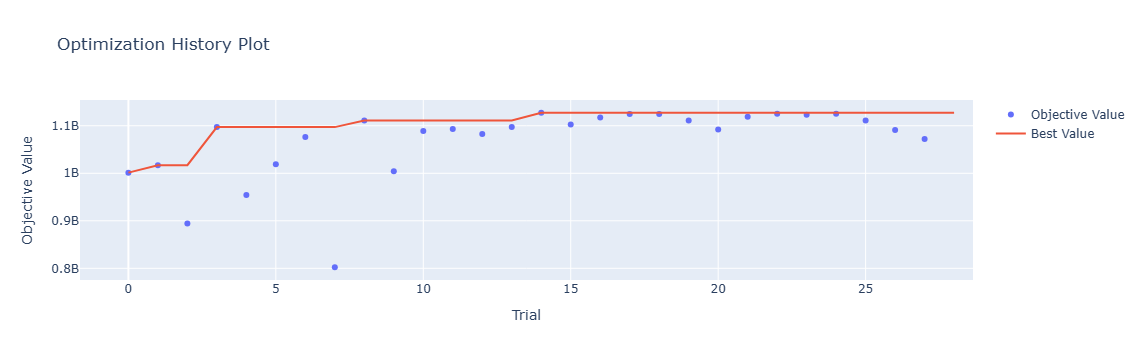

In [21]:
optuna.visualization.plot_optimization_history(study)

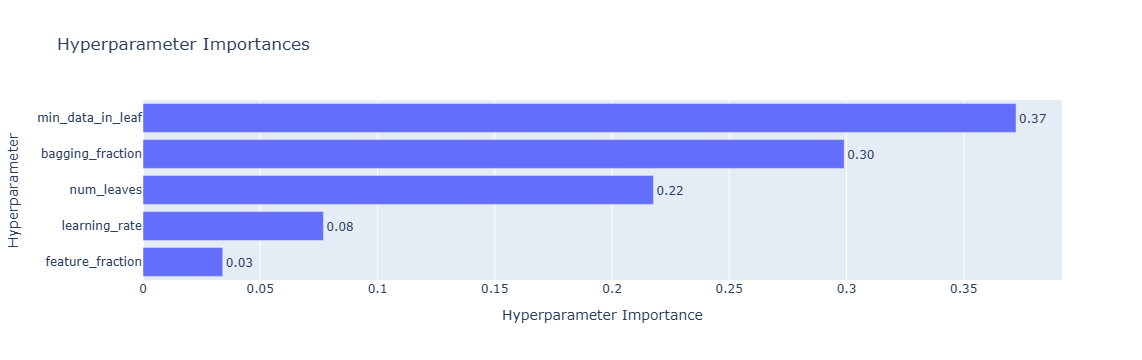

In [22]:
plot_param_importances(study)

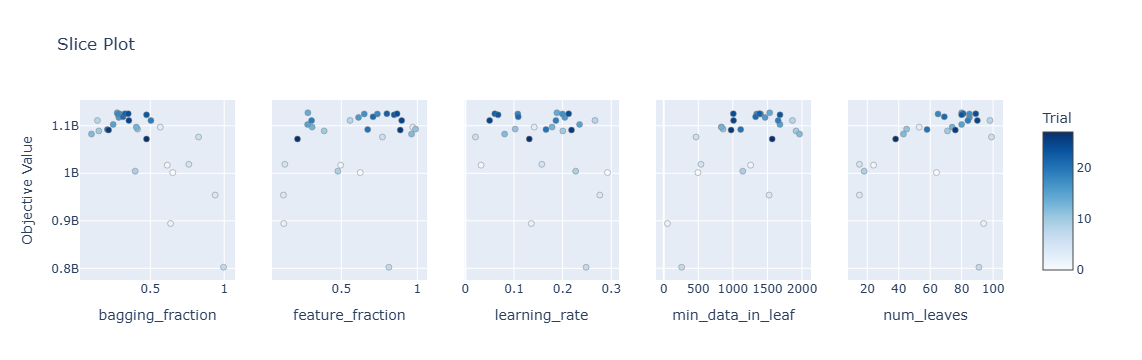

In [23]:
plot_slice(study)

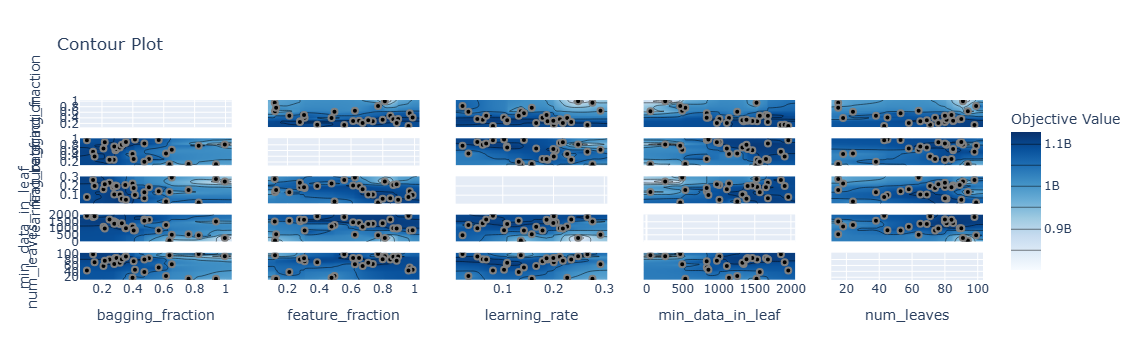

In [24]:
plot_contour(study)

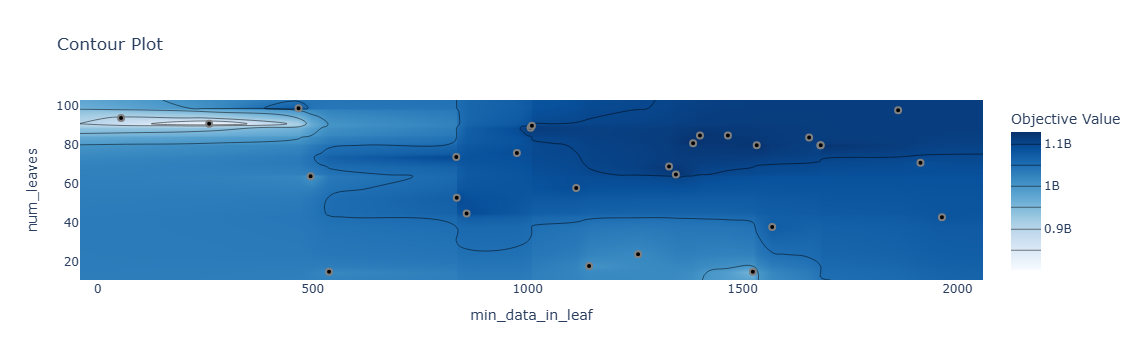

In [25]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

# 7.Entrenamiento

---

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [27]:
#Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos
cantidad_meses_train = 12  # Ejemplo: 6 meses para atrás desde 06/2021
ventana = 3
semillas=[100183,200003,300017,700001,800011]
# parametros de mejor modelo 
best_params = study.best_params
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
print(f"Mejores parámetros para el mejor modelo {best_params}")



Mejor cantidad de árboles para el mejor model 954
Mejores parámetros para el mejor modelo {'num_leaves': 80, 'learning_rate': 0.188236755684404, 'min_data_in_leaf': 1533, 'feature_fraction': 0.28030035172042733, 'bagging_fraction': 0.27600010045438145}


In [28]:

# Preparamos el conjunto de datos
train_data = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

# Bucle para entrenar un modelo para cada semilla y guardar cada modelo
for semilla in semillas:
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': study.best_trial.params['num_leaves'],
        'learning_rate': study.best_trial.params['learning_rate'],
        'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
        'feature_fraction': study.best_trial.params['feature_fraction'],
        'bagging_fraction': study.best_trial.params['bagging_fraction'],
        'seed': semilla,  # Usar la semilla actual del bucle
        'verbose': 0
    }
  # Entrenar el modelo con los parámetros actuales
    model_lgb = lgb.train(params,train_data, num_boost_round=best_iter)

 # Construir el nombre del archivo con la semilla, cantidad de meses y ventana
    model_filename = f'lgb_v5_semilla{semilla}_{cantidad_meses_train}_{ventana}_fev1.txt'
    #dataset_out = modelos_path +'/'+ model_filename
    dataset_out = dataset_path +'/'+ model_filename
    
    # Guardar el modelo en un archivo
    model_lgb.save_model(dataset_out)
    print(f'Modelo entrenado con semilla {semilla} y guardado en {dataset_out}')


Modelo entrenado con semilla 100183 y guardado en /home/ingceciliaconde/buckets/b1/datasets/lgb_v5_semilla100183_12_3_fev1.txt
Modelo entrenado con semilla 200003 y guardado en /home/ingceciliaconde/buckets/b1/datasets/lgb_v5_semilla200003_12_3_fev1.txt
Modelo entrenado con semilla 300017 y guardado en /home/ingceciliaconde/buckets/b1/datasets/lgb_v5_semilla300017_12_3_fev1.txt
Modelo entrenado con semilla 700001 y guardado en /home/ingceciliaconde/buckets/b1/datasets/lgb_v5_semilla700001_12_3_fev1.txt
Modelo entrenado con semilla 800011 y guardado en /home/ingceciliaconde/buckets/b1/datasets/lgb_v5_semilla800011_12_3_fev1.txt


Observamos variables mas importanes al modelo

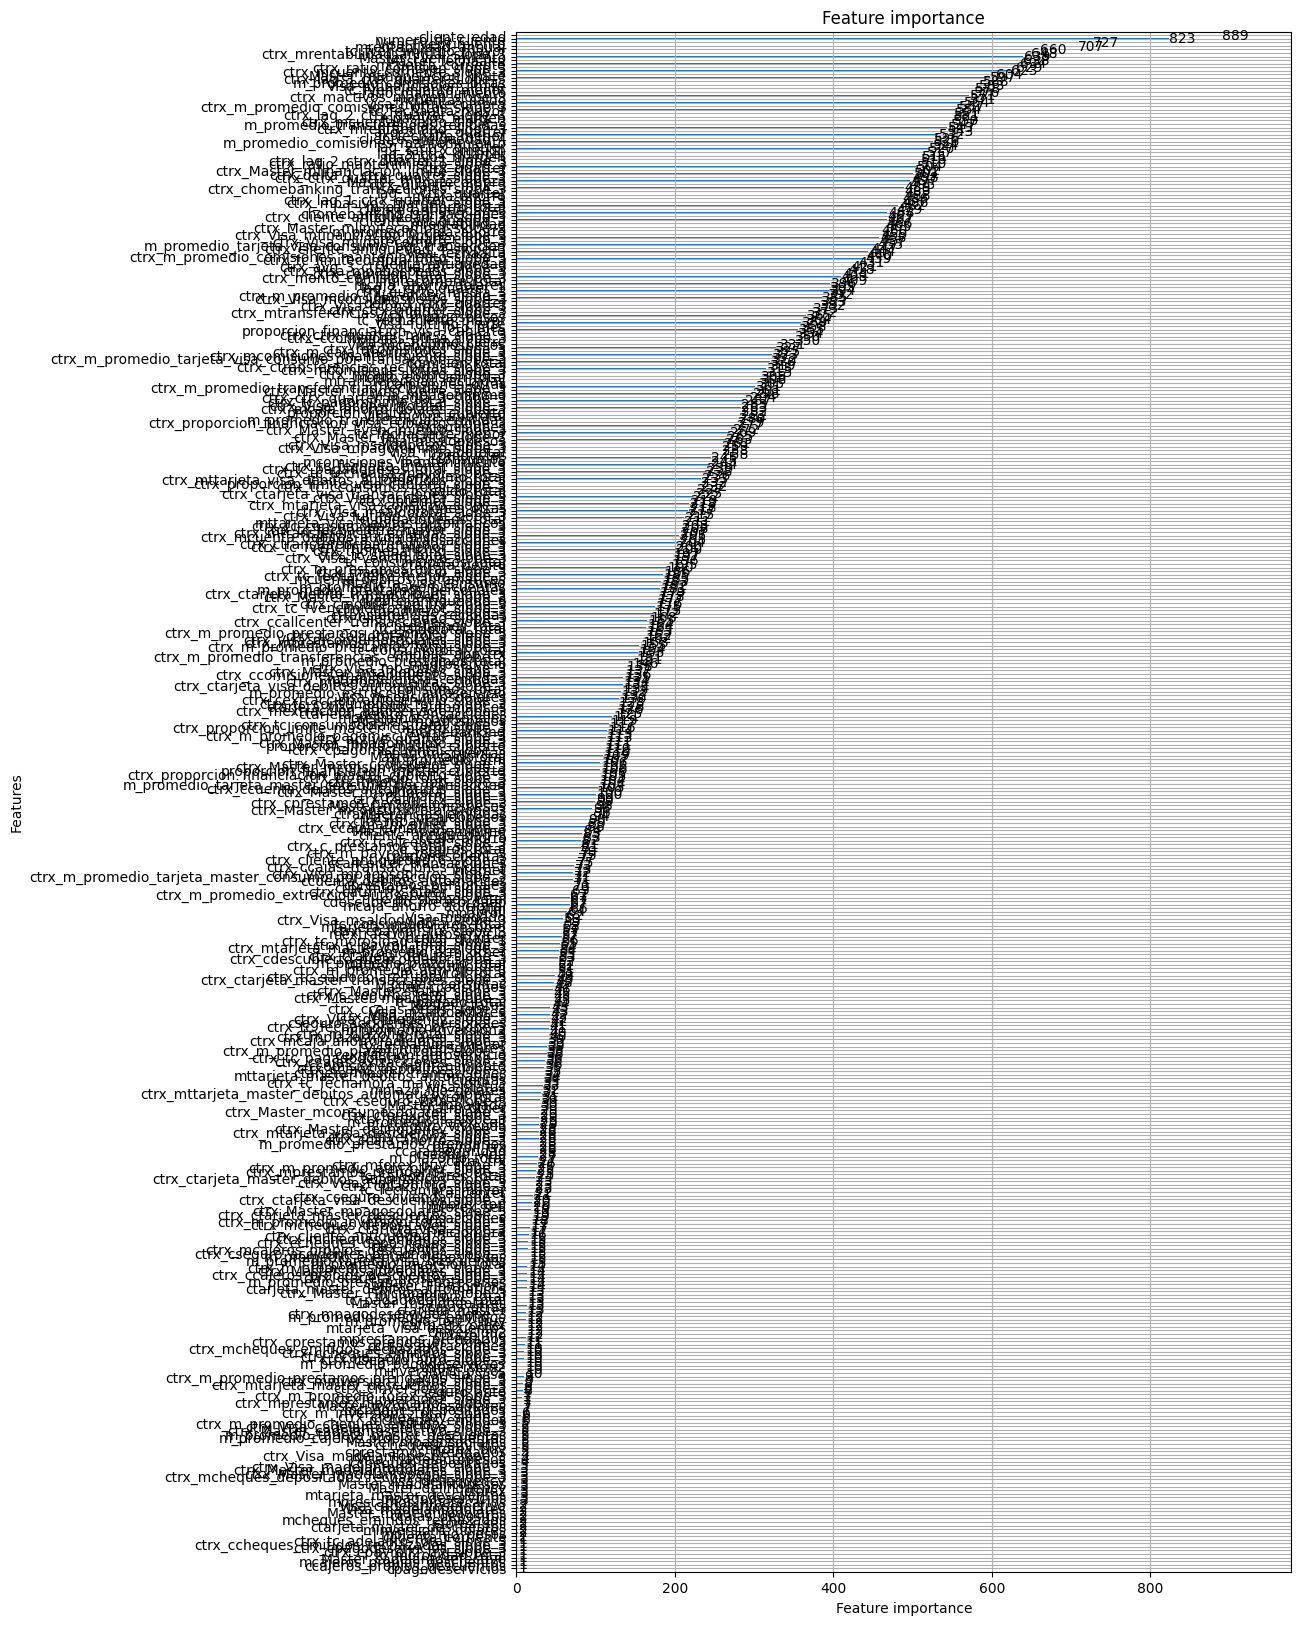

In [29]:
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de Dataframe:

In [30]:
#extraccion de feature importances
importances = model_lgb.feature_importance()
features = model_lgb.feature_name() #ian
#creo un dataframe para que sea mas facil de visualizar
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
#ordeno por importancia
importance_df = importance_df.sort_values('importance', ascending=False)

#show.
importance_df.head(100)

feature  importance
5                          cliente_edad         889
0                     numero_de_cliente         823
135                   Visa_Fvencimiento         727
8                  mrentabilidad_annual         707
154               tc_fvencimiento_mayor         660
..                                  ...         ...
308      ctrx_mcomisiones_otras_slope_3         315
179                monto_comision_total         308
81            mtransferencias_recibidas         308
74                    mcomisiones_otras         305
357  ctrx_Master_fultimo_cierre_slope_3         301

[100 rows x 2 columns]

# Guardar el modelo

In [ ]:
#8. Volvemos a leer el modelo.
#model_lgb = lgb.Booster(model_file= modelos_path + 'lgbm_{}_{}.txt'.format(cantidad_meses_train,ventana))

In [31]:
#prmer subida a kaggle
#a. Importo librería.
from kaggle.api.kaggle_api_extended import KaggleApi
#b. Configura el API de Kaggle
api = KaggleApi()
api.authenticate()

In [33]:
import os
import re

# Definimos el patrón de nombre que esperamos para los archivos de modelos
pattern = re.compile(r'^lgb_v5_semilla\d+_\d+_\d+_fev1\.txt$') #modificar segun nomrbre de archivo

# # Obtén la lista de archivos de modelos en el directorio que coinciden con el patrón
model_files = [f for f in os.listdir(dataset_path) if pattern.match(f)]
print(model_files)

['lgb_v5_semilla100183_12_3_fev1.txt', 'lgb_v5_semilla200003_12_3_fev1.txt', 'lgb_v5_semilla300017_12_3_fev1.txt', 'lgb_v5_semilla700001_12_3_fev1.txt', 'lgb_v5_semilla800011_12_3_fev1.txt']


In [36]:
import time  # Asegúrate de que esta importación está en la parte superior de tu script
# Parámetros de tu competencia y subidas
competencia = 'dm-ey-f-2024-segunda'
num_subida_kaggle = 1

# Bucle sobre cada archivo de modelo
for model_file in model_files:
    # Carga el modelo
    model_path = os.path.join(dataset_path, model_file)
    model_lgb = lgb.Booster(model_file=model_path)
    
    # Copia X_test para evitar añadir múltiples veces la columna 'Probabilidad'
    X_test_copy = X_test.copy()

    # Predecir con el modelo cargado
    predicciones = model_lgb.predict(X_test_copy)
    X_test_copy['Probabilidad'] = predicciones
    tb_entrega = X_test_copy.sort_values(by='Probabilidad', ascending=False)

    # Cortes candidatos y subidas
    cortes = range(9000, 14000, 500)
    for envios in cortes:
        tb_entrega['Predicted'] = 0
        tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
        resultados = tb_entrega[['numero_de_cliente', 'Predicted']].reset_index(drop=True)
        
        # Extraemos partes del nombre del archivo modelo para personalizar el mensaje y el nombre del archivo de subida
        info_modelo = model_file.replace(".txt", "").split("_")  # Suponiendo nombre como 'lgb_v5_semillaX_Y_Z.txt'
        semilla = info_modelo[2]  # Semilla usada
        mes_train = info_modelo[3]  # Meses de entrenamiento
        ventana = info_modelo[4]  # Ventana de tiempo
        
        nombre_archivo = f"C2_CC_12_fev1_00{num_subida_kaggle}_semilla{semilla}.csv"
        ruta_archivo = f"{exp_path}/{nombre_archivo}"
        resultados.to_csv(ruta_archivo, index=False)
        
        mensaje = f'Archivo {nombre_archivo}. Modelo: semilla{semilla}, meses train {mes_train}, DF {ventana}, fev1,  corte: {envios}'

        
        # Envío a Kaggle
        if num_subida_kaggle <= 15:
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
        else:
            print("Esperamos 30 segundos...")
            time.sleep(30)
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
        
        num_subida_kaggle += 1


100%|██████████| 1.93M/1.93M [00:00<00:00, 3.14MB/s]


Submission successful!


100%|██████████| 1.93M/1.93M [00:00<00:00, 2.91MB/s]


Submission successful!


100%|██████████| 1.93M/1.93M [00:00<00:00, 3.07MB/s]


Submission successful!


100%|██████████| 1.93M/1.93M [00:00<00:00, 3.11MB/s]


Submission successful!


100%|██████████| 1.93M/1.93M [00:00<00:00, 3.10MB/s]


Submission successful!


100%|██████████| 1.93M/1.93M [00:00<00:00, 3.21MB/s]
/home/ingceciliaconde/.venv/lib/python3.12/site-packages/kaggle/api/kaggle_api.py:1055: SyntaxWarning:

invalid escape sequence '\&'

/home/ingceciliaconde/.venv/lib/python3.12/site-packages/kaggle/api/kaggle_api.py:1076: SyntaxWarning:

invalid escape sequence '\&'

/home/ingceciliaconde/.venv/lib/python3.12/site-packages/kaggle/api_client.py:244: SyntaxWarning:

invalid escape sequence '\['

/home/ingceciliaconde/.venv/lib/python3.12/site-packages/kaggle/api_client.py:249: SyntaxWarning:

invalid escape sequence '\('



ApiException: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Mon, 18 Nov 2024 11:28:32 GMT', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Origin': '*', 'Set-Cookie': 'ka_sessionid=bb26ff5167a1a2f93b5d90ccd7f9d723; max-age=2626560; path=/, GCLB=CM3ou8X2uIO17gEQAw; path=/; HttpOnly', 'Vary': 'Accept-Encoding', 'X-Kaggle-MillisecondsElapsed': '106', 'X-Kaggle-RequestId': '081d20016fe0ac69ccc812c3915017f1', 'X-Kaggle-ApiVersion': '1.6.17', 'X-Kaggle-HubVersion': '0.3.4', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-etZdj8uOZRe3ufN5YKGxmA==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kkb-production.jupyter-proxy.kaggle.net https://kkb-production.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com https://calendar.google.com/ ;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'Transfer-Encoding': 'chunked'})
HTTP response body: {"code":400,"message":"Submission not allowed:  Your team has used its daily Submission allowance (100) today, please try again tomorrow UTC (12 hours from now)."}


#Corrida de Modelo optimidazo los hiperparametros

In [ ]:
# Ensamble de probabilidades
import pandas as pd
import numpy as np
import os
import time

# Inicialización de DataFrame para almacenar todas las predicciones
df_predicciones = pd.DataFrame()

# Bucle sobre cada archivo de modelo para cargar y predecir
for model_file in model_files:
    model_path = os.path.join(dataset_path, model_file)
    model_lgb = lgb.Booster(model_file=model_path)
    
    # Copia X_test para evitar añadir múltiples veces la columna 'Probabilidad'
    X_test_copy = X_test.copy()
    
    # Predecir con el modelo cargado y almacenar las probabilidades
    predicciones = model_lgb.predict(X_test_copy)
    df_predicciones[model_file] = predicciones




In [ ]:
# Asegurarse de que ambos DataFrames tienen el mismo índice
if not df_predicciones.index.equals(X_test.index):
    print("Los índices no son iguales. Realineando...")
    df_predicciones.index = X_test.index

# Verificar que las columnas esperadas estén presentes y que no haya NaNs
print(df_predicciones.head())
print("¿Hay valores NaN en las predicciones?:", df_predicciones.isna().any().any())




In [ ]:
# Calcular la media de las predicciones de todos los modelos
X_test['Probabilidad'] = df_predicciones.mean(axis=1)
tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)


In [ ]:
# Ver el DataFrame final para confirmar que los datos son correctos
print(X_test[['numero_de_cliente', 'Probabilidad']].head())


In [ ]:
import time
# Asegúrate de que num_subida_kaggle esté inicializado
# Parámetros de tu competencia y subidas
competencia = 'dm-ey-f-2024-segunda'
#num_subida_kaggle = 1  # o cargar el último valor si estás continuando subidas previas

# Cortes candidatos y subidas
cortes = range(9000, 14000, 500)
for envios in cortes:
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
    resultados = tb_entrega[['numero_de_cliente', 'Predicted']].reset_index(drop=True)
    
    nombre_archivo = f"C2_CC_12_prueba_ensamblepromedio{num_subida_kaggle}.csv"
    ruta_archivo = f"{exp_path}/{nombre_archivo}"
    resultados.to_csv(ruta_archivo, index=False)
    
    mensaje = f'Archivo {nombre_archivo}. Ensamble, DF {ventana}, dato original, punto_corte: {envios}.'
    
    # Envío a Kaggle
    if num_subida_kaggle <= 15:
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
    else:
        print("Esperamos 30 segundos...")
        time.sleep(30)
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
    
    num_subida_kaggle += 1
